In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def generate_data(
    x,
    amplitudes=[1.0, 2.0, 0.5, 0.0],  # 0.0 amplitude means "unused" peak
    centers=[0.0, 2.0, -2.0, 5.0],
    widths=[0.5, 0.7, 0.3, 1.0],
    noise_std=0.05
):
    """
    Create synthetic data as a sum of Gaussians, possibly with some noise.
    If an amplitude is zero, that effectively removes that Gaussian peak.
    """
    y = np.zeros_like(x, dtype=np.float32)
    for amp, c, w in zip(amplitudes, centers, widths):
        if amp != 0.0:
            y += amp * np.exp(-0.5 * ((x - c) / w) ** 2)
    # Add Gaussian noise to simulate measurement
    noise = np.random.normal(0.0, noise_std, size=x.shape).astype(np.float32)
    return y + noise


In [3]:
# Define an x-axis for our synthetic data
x_data = np.linspace(-5, 10, 300).astype(np.float32)

# True parameters for synthetic data (adjust as needed)
true_amplitudes = [1.5, 2.7, 0.8, 1.0]
true_centers    = [ 0.0,  2.2, -2.0, 6.5]
true_widths     = [ 0.5,  0.8,  0.4, 0.9]

# Generate synthetic signal
y_data = generate_data(
    x_data,
    amplitudes=true_amplitudes,
    centers=true_centers,
    widths=true_widths,
    noise_std=0.05
)

In [4]:
initial_amplitudes = tf.Variable([1.0, 1.0, 1.0, 1.0], dtype=tf.float32)
initial_centers    = tf.Variable([0.0, 1.0, -1.0, 4.0], dtype=tf.float32)
initial_widths     = tf.Variable([0.5, 0.5, 0.5, 0.5], dtype=tf.float32)

In [7]:
def multi_gaussian_model(x):
    """
    Returns the sum of up to 4 Gaussians using the current
    trainable TF variables.
    """
    gaussians = []
    for i in range(4):
        amp = initial_amplitudes[i]
        cen = initial_centers[i]
        wid = tf.math.abs(initial_widths[i])  # enforce positivity
        peak = amp * tf.exp(-0.5 * ((x - cen) / wid) ** 2)
        gaussians.append(peak)
    return tf.reduce_sum(gaussians, axis=0)

def loss_fn(x, y):
    y_pred = multi_gaussian_model(x)
    return tf.reduce_mean((y - y_pred) ** 2)


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

loss_history = []

# Convert data to TF tensors (for convenience)
x_tf = tf.constant(x_data, dtype=tf.float32)
y_tf = tf.constant(y_data, dtype=tf.float32)

# Number of epochs for demonstration
epochs = 3000

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(x_tf, y_tf)
        
    grads = tape.gradient(current_loss, [initial_amplitudes, initial_centers, initial_widths])
    optimizer.apply_gradients(zip(grads, [initial_amplitudes, initial_centers, initial_widths]))
    
    loss_history.append(current_loss.numpy())
    
    # (Optional) Print progress occasionally
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss = {current_loss.numpy():.6f}")

###############################################################################
# 6. Evaluate and Print Results
###############################################################################
final_loss = loss_fn(x_tf, y_tf).numpy()
print("\nTraining finished.")
print("Final Loss =", final_loss)

print("\nRetrieved Parameters:")
print("Amplitudes:", initial_amplitudes.numpy())
print("Centers:   ", initial_centers.numpy())
print("Widths:    ", initial_widths.numpy())

# Compare with the true parameters
print("\nTrue Parameters:")
print("Amplitudes:", true_amplitudes)
print("Centers:   ", true_centers)
print("Widths:    ", true_widths)

Epoch     0 | Loss = 0.722875
Epoch   500 | Loss = 0.054754
Epoch  1000 | Loss = 0.040099
Epoch  1500 | Loss = 0.034196
Epoch  2000 | Loss = 0.002524
Epoch  2500 | Loss = 0.002524

Training finished.
Final Loss = 0.0025240448

Retrieved Parameters:
Amplitudes: [1.5032027  2.6910422  0.79126525 0.9827781 ]
Centers:    [-3.2528487e-03  2.1897035e+00 -1.9851452e+00  6.5060668e+00]
Widths:     [0.491903   0.8125394  0.39241838 0.90456986]

True Parameters:
Amplitudes: [1.5, 2.7, 0.8, 1.0]
Centers:    [0.0, 2.2, -2.0, 6.5]
Widths:     [0.5, 0.8, 0.4, 0.9]


In [10]:
y_fit = multi_gaussian_model(x_tf).numpy()

plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, s=10, alpha=0.5, label='Noisy Data')
plt.plot(x_data, y_fit, 'r-', label='Fitted Sum of Gaussians', linewidth=2)

# Optionally, you can also plot each individual peak
for i in range(4):
    amp = initial_amplitudes[i].numpy()
    cen = initial_centers[i].numpy()
    wid = abs(initial_widths[i].numpy())
    single_peak = amp * np.exp(-0.5 * ((x_data - cen) / wid) ** 2)
    plt.plot(x_data, single_peak, '--', label=f'Peak {i+1}')

plt.title('Fitting Up To Four Gaussian Peaks with TensorFlow')
plt.xlabel('x')
plt.ylabel('Signal')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

###############################################################################
# 1. Create a Synthetic Dataset of 1D Signals (sum of up to 4 Gaussians)
###############################################################################

def generate_random_signal(n_points=100, max_peaks=4, noise_std=0.02):
    """
    Generate a single 1D signal of length `n_points` containing up to `max_peaks` Gaussians
    with random amplitudes, centers, and widths. We add Gaussian noise as well.
    """
    x = np.linspace(-5, 5, n_points)  # or any domain you like
    y = np.zeros_like(x)
    
    n_peaks = np.random.randint(1, max_peaks+1)  # 1 to max_peaks
    
    for _ in range(n_peaks):
        amp = np.random.uniform(2.0, 2.0)
        cen = np.random.uniform(-2.0, 2.0)
        wid = np.random.uniform(0.2, 0.2)
        y += amp * np.exp(-0.5 * ((x - cen)/wid)**2)
    
    # Add noise
    y += np.random.normal(0.0, noise_std, size=n_points)
    
    return x, y


In [54]:

# Generate a dataset of multiple signals
n_samples = 2000
n_points = 200
X_data = []
for _ in range(n_samples):
    x_positions, y_signal = generate_random_signal(n_points=n_points, max_peaks=3, noise_std=0.00)
    X_data.append(y_signal)

X_train = np.array(X_data, dtype=np.float32)  # shape: (n_samples, n_points)


Dataset shape: (2000, 100)


Model: "Gaussian_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ signal_input (InputLayer)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ param_output (Dense)            │ (None, 12)             │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_decoder                │ (None, 100)            │             0 │
│ (GaussianDecoder)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,404 (44.55 KB)

 Trainable params: 11,404 (44.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3634 - val_loss: 0.1743
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.1549 - val_loss: 0.1402
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.1229 - val_loss: 0.1257
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.1157 - val_loss: 0.1173
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.1035 - val_loss: 0.1042
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0922 - val_loss: 0.0963
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0823 - val_loss: 0.0904
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0783 - val_loss: 0.0822
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.0768 - val_loss: 0.0755
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 0.0616 - val_loss: 0.0674
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0607 - val_loss: 0.0648
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step -

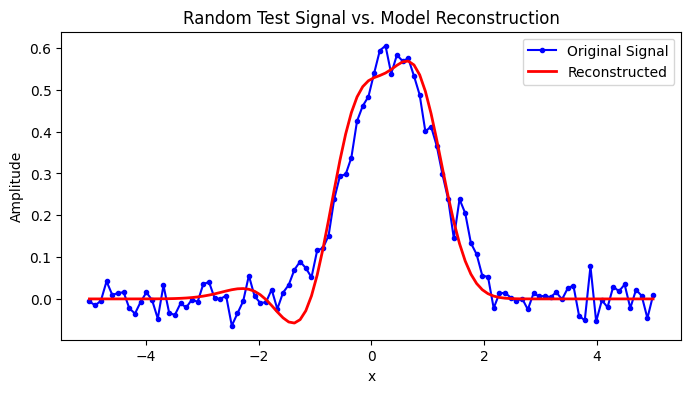

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Retrieved Parameters:
Peak 1: amp=-1.409, center=-0.909, width=0.621
Peak 2: amp=-0.217, center=0.332, width=0.585
Peak 3: amp=0.508, center=0.817, width=0.464
Peak 4: amp=1.607, center=-0.658, width=0.743


In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

##############################################################################
# 1. Generate Synthetic Dataset
##############################################################################
def generate_random_signal(n_points=100, max_peaks=4, noise_std=0.02):
    """
    Generate a 1D signal of length n_points containing up to max_peaks Gaussians,
    plus Gaussian noise. Returns just the y-values; we assume a common x-axis.
    """
    x = np.linspace(-5, 5, n_points)
    y = np.zeros_like(x)
    
    n_peaks = np.random.randint(1, max_peaks+1)  # choose 1 to max_peaks
    for _ in range(n_peaks):
        amp = np.random.uniform(0.5, 2.0)
        cen = np.random.uniform(-4.0, 4.0)
        wid = np.random.uniform(0.2, 1.0)
        y += amp * np.exp(-0.5 * ((x - cen)/wid)**2)
    
    # Add noise
    y += np.random.normal(0.0, noise_std, size=n_points)
    return y.astype(np.float32)

# Create multiple signals
n_samples = 2000
n_points  = 100
X_data    = []
for _ in range(n_samples):
    y_signal = generate_random_signal(n_points=n_points, max_peaks=4, noise_std=0.03)
    X_data.append(y_signal)

X_data = np.array(X_data, dtype=np.float32)  # shape (n_samples, n_points)
print("Dataset shape:", X_data.shape)         # (2000, 100)

# Train/test split
split_idx = int(0.8 * n_samples)
X_train = X_data[:split_idx]  # (1600, 100)
X_test  = X_data[split_idx:]  # (400,  100)

# We'll use the same x-axis for all signals
x_positions = np.linspace(-5, 5, n_points).astype(np.float32)  # shape (100,)

##############################################################################
# 2. Custom Decoder Layer: Summation of Up To 4 Gaussians
##############################################################################
class GaussianDecoder(layers.Layer):
    """
    Takes a batch of parameter vectors of length 12:
      [amp1, amp2, amp3, amp4, cen1, cen2, cen3, cen4, w1, w2, w3, w4]
    Returns a batch of reconstructed signals of length n_points,
    by summing 4 Gaussians defined on x_positions.
    """
    def __init__(self, x_positions, num_peaks=4, **kwargs):
        super().__init__(**kwargs)
        self.x_positions = tf.constant(x_positions, dtype=tf.float32)  # shape (N,)
        self.num_peaks   = num_peaks
        self.N           = x_positions.shape[0]

    def call(self, inputs):
        """
        inputs shape: (batch_size, 3*num_peaks) = (batch_size, 12)
        output shape: (batch_size, N)
        """
        batch_size = tf.shape(inputs)[0]

        # Split into amplitude, center, and "raw" width
        amps    = inputs[:, 0:self.num_peaks]                   # (batch_size, 4)
        centers = inputs[:, self.num_peaks:2*self.num_peaks]    # (batch_size, 4)
        raw_w   = inputs[:, 2*self.num_peaks:3*self.num_peaks]  # (batch_size, 4)

        # Force widths to be positive
        widths  = tf.nn.softplus(raw_w) + 1e-6                  # (batch_size, 4)

        # Expand x_positions to shape (batch_size, num_peaks, N) via tiling
        x_2d = tf.reshape(self.x_positions, [1, self.N])               # (1, N)
        x_3d = tf.tile(x_2d[None, :, :], [batch_size, self.num_peaks, 1])  
        # => (batch_size, 4, N)

        # Expand amps, centers, widths to (batch_size, 4, 1)
        amps_3d    = amps[:, :, None]    
        centers_3d = centers[:, :, None]
        widths_3d  = widths[:, :, None]

        # Compute Gaussians => shape (batch_size, 4, N)
        gaussians = amps_3d * tf.exp(-0.5 * tf.square((x_3d - centers_3d) / widths_3d))

        # Sum across the 4 peaks => (batch_size, N)
        output = tf.reduce_sum(gaussians, axis=1)
        return output

##############################################################################
# 3. Build the Physics-Informed Autoencoder
##############################################################################
def build_physics_informed_autoencoder(n_points=100, num_peaks=4):
    """
    - Input: (n_points,) i.e. a single signal.
    - Encoder: Maps the signal to 3*num_peaks parameters.
    - Decoder: Summation of up to 4 Gaussians to reconstruct the signal.
    """
    inputs = layers.Input(shape=(n_points,), name="signal_input")

    # Encoder: a few Dense layers
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)

    # Output 12 parameters (3 per peak) => amps, centers, widths
    param_output = layers.Dense(3 * num_peaks, activation='linear', name="param_output")(x)

    # Decoder: custom layer that converts (batch_size, 12) -> (batch_size, n_points)
    reconstructed_signal = GaussianDecoder(
        x_positions=x_positions,
        num_peaks=num_peaks,
        name="gaussian_decoder"
    )(param_output)

    # Build and compile
    model = models.Model(inputs=inputs, outputs=reconstructed_signal, name="Gaussian_AE")
    return model

# Instantiate the model
model = build_physics_informed_autoencoder(n_points=n_points, num_peaks=4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'
)
model.summary()

##############################################################################
# 4. Train the Model (No Manual Loop)
##############################################################################
# We'll do an autoencoder approach: input = signal, target = same signal
history = model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

##############################################################################
# 5. Evaluate and Plot a Test Sample
##############################################################################
print("\nTraining completed.")
print("Final training loss:", history.history["loss"][-1])
print("Final validation loss:", history.history["val_loss"][-1])

# Pick a random test signal and reconstruct
idx = np.random.randint(0, X_test.shape[0])
test_signal = X_test[idx]                # shape (100,)
test_signal = test_signal[None, :]       # shape (1, 100) for predict

reconstructed = model.predict(test_signal)[0]  # shape (100,)

# Compare visually
x_axis = x_positions  # same for all signals
plt.figure(figsize=(8,4))
plt.plot(x_axis, test_signal[0], 'bo-', markersize=3, label='Original Signal')
plt.plot(x_axis, reconstructed, 'r-', label='Reconstructed', linewidth=2)
plt.title("Random Test Signal vs. Model Reconstruction")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

##############################################################################
# 6. (Optional) Extract Learned Parameters
##############################################################################
# Create an "encoder" model that outputs the 12 parameters
encoder = models.Model(
    inputs=model.input,
    outputs=model.get_layer("param_output").output
)

params = encoder.predict(test_signal)  # shape (1, 12)
params = params[0]                    # shape (12,)

amps    = params[:4]
centers = params[4:8]
raw_w   = params[8:12]
widths  = tf.nn.softplus(raw_w).numpy()

print("\nRetrieved Parameters:")
for i in range(4):
    print(f"Peak {i+1}: amp={amps[i]:.3f}, center={centers[i]:.3f}, width={widths[i]:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


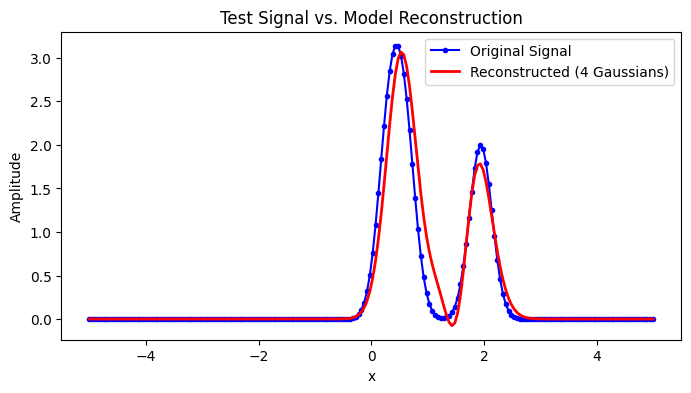

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Retrieved Parameters for that sample:
Amplitudes: [ 3.3765237  3.0613883 -2.9836874  1.6820441]
Centers:    [ 0.53587097  1.5501328  -0.9465287  -1.1973768 ]
Widths:     [0.2287198]


In [63]:
# Let's pick a random test sample and see how well the model reconstructs it
idx = np.random.randint(0, X_train.shape[0])
test_signal = X_train[idx]          # shape (100,)
test_signal = test_signal[np.newaxis, :]  # shape (1, 100) for predict

reconstructed = model.predict(test_signal)[0]  # shape (100,)

# Compare
plt.figure(figsize=(8,4))
plt.plot(x_positions, test_signal[0], 'bo-', markersize=3, label='Original Signal')
plt.plot(x_positions, reconstructed, 'r-', label='Reconstructed (4 Gaussians)', linewidth=2)
plt.title("Test Signal vs. Model Reconstruction")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

###############################################################################
# 6. Retrieve Fitted Parameters for a Given Signal
###############################################################################
# If you want to retrieve the 12 parameters for a given signal, create a sub-model
# that stops at the "param_output" layer:

encoder = models.Model(
    inputs=model.input,
    outputs=model.get_layer("param_output").output
)

params = encoder.predict(test_signal)  # shape (1, 12)
params = params[0]                    # shape (12,)

amps    = params[:4]
centers = params[4:8]
widths  = params[8:12]
widths  = tf.nn.softplus(widths).numpy()  # ensure positivity

print("\nRetrieved Parameters for that sample:")
print("Amplitudes:", amps)
print("Centers:   ", centers)
print("Widths:    ", widths)
